In [55]:
from importlib import reload
import numpy as np

import src.music.mir
reload(src.music.mir)
import src.music
reload(src.music)
from src.music import MusicInformationRetreiver
from src.speech import SpeechInformationRetreiver
import matplotlib.pyplot as plt

In [44]:
music_path = 'assets/ambienceTrack_001(1).mp3'
speech_path = 'assets/LANDR- Meditation- Transcend 15 Mins-Balanced-Medium.mp3'


mir = MusicInformationRetreiver(weights_path='mir_weights/', distance_threshold=0.1)
# sir = SpeechInformationRetreiver(
#     model_name='stt_en_fastconformer_hybrid_large_streaming_1040ms',
#     lookahead_size=1040,
#     decoder_type='rnnt',
#     device='cpu'
# )

[   INFO   ] TensorflowPredict: Successfully loaded graph file: `mir_weights//discogs-effnet-bs64-1.pb`
[   INFO   ] TensorflowPredict: Successfully loaded graph file: `mir_weights//mtg_jamendo_genre-discogs-effnet-1.pb`
[   INFO   ] TensorflowPredict: Successfully loaded graph file: `mir_weights//mtg_jamendo_instrument-discogs-effnet-1.pb`
[   INFO   ] TensorflowPredict: Successfully loaded graph file: `mir_weights//msd-musicnn-1.pb`
[   INFO   ] TensorflowPredict: Successfully loaded graph file: `mir_weights//emomusic-msd-musicnn-2.pb`


In [45]:
asr_res = sir.recognize_file(speech_path)
mir_res = mir.recognize_file(music_path)

  0%|          | 0/30 [00:00<?, ?it/s]

[   INFO   ] TensorflowPredict: Successfully loaded graph file: `mir_weights//mtg_jamendo_genre-discogs-effnet-1.pb`
[   INFO   ] TensorflowPredict: Successfully loaded graph file: `mir_weights//mtg_jamendo_instrument-discogs-effnet-1.pb`


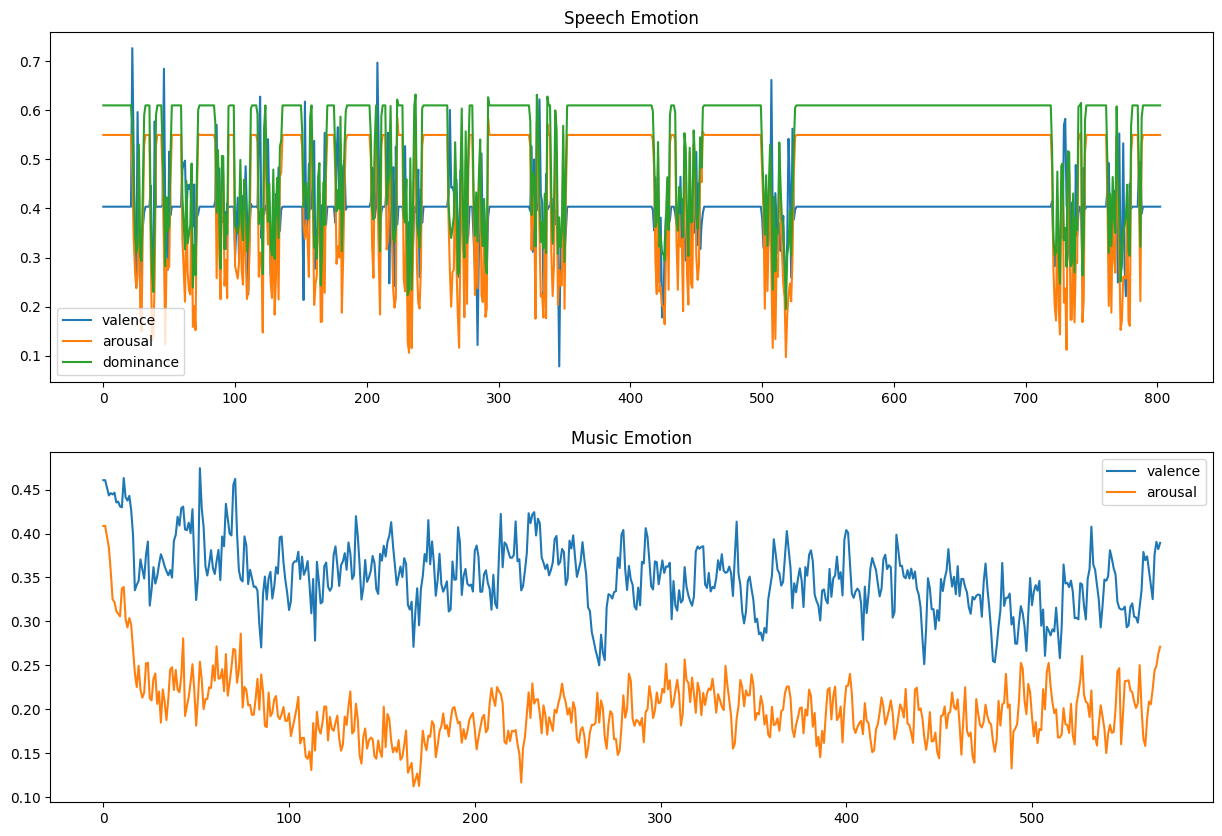

In [46]:
plt.figure(figsize=(15, 10))
plt.subplot(211)
plt.title('Speech Emotion')
plt.plot(asr_res['valence'], label='valence')
plt.plot(asr_res['arousal'], label='arousal')
plt.plot(asr_res['dominance'], label='dominance')
plt.legend()

plt.subplot(212)
plt.title('Music Emotion')
plt.plot(mir_res['valence'], label='valence')
plt.plot(mir_res['arousal'], label='arousal')
plt.legend()

In [89]:
import seaborn as sns
from collections import Counter


def extract_segments(speech_res, music_res, genre_classes, inst_classes):
    prev = 0
    bounds = np.append(music_res['segments'][1:], music_res['length'])
    segments = []
    n_speech_emo = len(speech_res['emotion_labels'])
    n_speech_emo_dim = len(speech_res['valence'])
    n_music_emo = len(music_res['valence'])
    n_music_tag = len(music_res['genre'])
    for end in bounds:
        seg = {'start' : prev, 'end': end, 'duration': end - prev, 'music': {}, 'speech': {}}

        ## Speech
        idx1 = int(prev * n_speech_emo // speech_res['length']) + 1
        idx2 = int(end * n_speech_emo // speech_res['length'])
    
        seg['speech']['emotion_label'] = Counter(speech_res['emotion_labels'][idx1:idx2]).most_common(n=1)[0][0]
    
        idx1 = int(prev * n_speech_emo_dim // speech_res['length']) + 1
        idx2 = int(end * n_speech_emo_dim // speech_res['length'])
        for dim in ['valence', 'arousal', 'dominance']:
            seg['speech'][dim] = speech_res[dim][idx1:idx2].mean()
    
        idx1 = int(prev * n_music_emo // music_res['length']) + 1
        idx2 = int(end * n_music_emo // music_res['length'])
        for dim in ['valence', 'arousal']:
            seg['music'][dim] = music_res[dim][idx1:idx2].mean()
    
        idx1 = int(prev * n_music_emo // music_res['length']) + 1
        idx2 = int(end * n_music_emo // music_res['length'])
        
        genre = music_res['genre'][idx1:idx2].mean(axis=0)
        genre_ids = np.where(genre > 0.5)[0]
        seg['music']['genre'] = dict([(genre_classes[gid], genre[gid]) for gid in genre_ids])
        
        instrument = music_res['instrument'][idx1:idx2].mean(axis=0)
        inst_ids = np.where(instrument > 0.5)[0]
        seg['music']['instrument'] = dict([(inst_classes[iid], instrument[iid]) for iid in inst_ids])
    
        
        beats = music_res['beats'][:, 0]
        n_beats = sum((beats > prev) & (beats < end))
        seg['music']['tempo'] = n_beats * 60 // (end - prev)
        
        segments += [seg]
        prev = end
    return segments

In [92]:
segments = extract_segments(asr_res, mir_res, mir.genre_classes, mir.inst_classes)

In [93]:
segments

[{'start': 0,
  'end': 128.32,
  'duration': 128.32,
  'music': {'valence': 0.39170396,
   'arousal': 0.24892677,
   'genre': {'ambient': 0.5415719},
   'instrument': {'synthesizer': 0.5565371},
   'tempo': 74.0},
  'speech': {'emotion_label': 'neu',
   'valence': 0.40308293274470736,
   'arousal': 0.4296221202904625,
   'dominance': 0.5016582747921348}},
 {'start': 128.32,
  'end': 463.2,
  'duration': 334.88,
  'music': {'valence': 0.35359144,
   'arousal': 0.18038745,
   'genre': {'ambient': 0.76583874},
   'instrument': {'synthesizer': 0.68219036},
   'tempo': 66.0},
  'speech': {'emotion_label': 'neu',
   'valence': 0.39849369440038324,
   'arousal': 0.4561273265440585,
   'dominance': 0.5272915943699368}},
 {'start': 463.2,
  'end': 555.392,
  'duration': 92.19200000000006,
  'music': {'valence': 0.3509278,
   'arousal': 0.21227087,
   'genre': {'ambient': 0.7953669},
   'instrument': {'synthesizer': 0.6808386},
   'tempo': 164.0},
  'speech': {'emotion_label': 'neu',
   'valence

In [94]:
asr_res['text']

"welcome to this meditation journey where you will find calm amidst the turbulence of the seaman i'll be your guide a comfortable seated or lying position and gently close your eyes by taking a few deep breaths allowing your body to relax your mind to settle imagine yourself on a small vessel at sea gently being carried by the swells the whole ocean seems to be an upheaval around you yet beneath the surface the depth of the ocean is at rest the vastness of the ocean its waves rising falling but would feel the stillness at its core now select mantra resonates with you it could be a simple sound like any word or phrase that brings you peace as you begin to produce this mantra synchronize it with the rhythm of your breath with each repetition of yomantra allow the music to quiet your mind let the soothing melodies was overview crediting you deeper into a state of tranquillity feel the swells of the music mirroring the rise and fall of the ocean as you continue to produce your chosen mantr

In [99]:
import torch
from muse import PipelineMuse

pipe = PipelineMuse.from_pretrained("openMUSE/muse-512-finetuned")
# pipe.transformer.enable_xformers_memory_efficient_attention()

[NeMo W 2024-07-10 01:39:26 nemo_logging:349] /Users/soroush/lucid_env/lib/python3.10/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
      warnings.warn(
    


  0%|          | 0/16 [00:00<?, ?it/s]

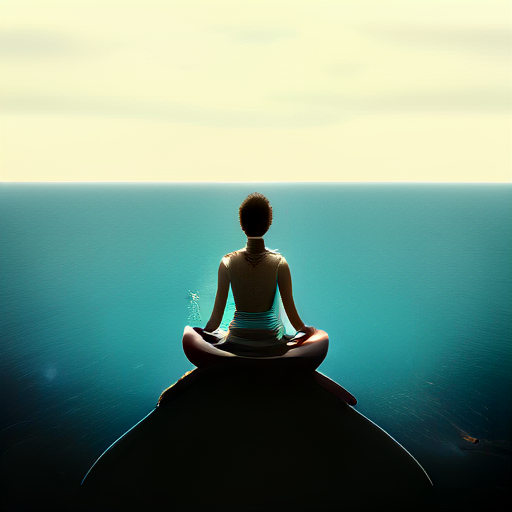

In [98]:
images = pipe(
  asr_res['text'], timesteps=16, guidance_scale=10, transformer_seq_len=1024, use_fp16=True
)
images[0]